<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/macro_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!pip install wandb
!git clone https://github.com/Krankile/npmf.git

In [3]:
%%capture
!cd npmf && git pull

In [4]:
%%capture
!pip install wandb

In [5]:
!wandb login

wandb: Currently logged in as: kjartan (krankile). Use `wandb login --relogin` to force relogin


##General setup

In [6]:
import os
from collections import defaultdict
from collections import Counter
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.eikon import column_mapping
from npmf.utils.wandb import get_dataset, put_dataset

In [60]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
np.random.seed(420)

# Clean some macro data 😂✨KAWAIII ^^✨ 




In [113]:
macro_df = get_dataset("macro-data:latest", project="master-test").rename(columns=column_mapping)
values_count = macro_df.count(axis=0, numeric_only=True).sum()

In [118]:
values_count

103129

Originally we have $\mathcal{D}^{macro}_T$ = 103,129

Now, some Na values can exist in the timeseries, however we should exclude some macro variables if they are almost never reported. 

In [114]:
def data_left_per_columns(df):
    data_dict = {}
    for column in df.columns:
        data_dict[column] = df[column].dropna().shape[0]


    xs = list(zip(*data_dict.items()))[0]
    ys = np.array(list(zip(*data_dict.items()))[1])/df.shape[0]
    return xs, ys

In [115]:
def plot_data_over_time(df, start_year_m2000, end_year_m2000, cap_p_in_2010):
    lost_series = []
    year_data = {}
    initialised = False
    years = []
    for year in [365*i for i in range(start_year_m2000, end_year_m2000)]:
        year_formated = "'" + f"{int(2000 + year/365)}"[2:4] 
        years.append(year_formated)
        
        tickers, non_na_count = data_left_per_columns(df.iloc[:year,:])
        if not initialised:
            initialised = True
            for i in range(len(tickers)):
                year_data[tickers[i]] = []

        for i in range(len(tickers)):
            year_data[tickers[i]] += [non_na_count[i]]
    for ticker in year_data:    
        if year_data[ticker][9] < cap_p_in_2010:
            lost_series.append(ticker)
            color = main2
            ticker_name = ticker
        else:
            color = main
            ticker_name = None
        plt.plot(years, year_data[ticker], label=ticker_name, color=color)
    plt.plot(years, [cap_p_in_2010]*len(years), color= "grey", linestyle="-.")
    plt.vlines(9, 0, 1, color="grey", linestyle="-.")
    plt.xlabel("Year")
    plt.ylabel("Entries % of days from 2000")
    plt.legend(frameon=False)
    plt.show()
    return lost_series

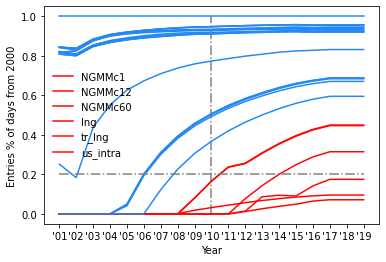

In [116]:
lost_series = plot_data_over_time(macro_df,1,20,.2)

In [117]:
macro_df = macro_df.drop(columns=lost_series)
values_left = macro_df.count(axis=0, numeric_only=True).sum()
values_left

93681

$\mathcal{D}^{macro}_T$ = 93,681, is left when we drop the red time series above

In [122]:
set(list(macro_df.date.diff()))

#Largest gap in macro data is 3 days, which probably makes sense during holidays, etc.  

{NaT,
 Timedelta('1 days 00:00:00'),
 Timedelta('2 days 00:00:00'),
 Timedelta('3 days 00:00:00')}

Well, there is not much more to be doing... the macrodata (given our assumptions) looks good at this point. 

In [124]:
put_dataset(macro_df, filename="macro-final.feather", project="master")